In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
!pip install fiona
import fiona
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18
from torchvision.utils import draw_segmentation_masks

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

import json
from os import listdir
from os import path

from typing import Tuple, List, Callable, Iterator, Optional, Dict, Any
from collections import defaultdict

from google.colab import drive 
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 24.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 4.1 MB/s 
     |████████████████████████████████| 376 kB 23.6 MB/s 
     |████████████████████████████████| 58 kB 5.4 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=dc3c18f5ca2eb86e239310fbdb9780d52dcb2c483d08aef20f4e49b37a803197
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=d806d2e4c57636609fc4dd61a0b3b511b39e0e9f5cb3319475fa1d360b35f327
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfull

## Класс для загрузки датасета


In [ ]:
class EyeDataset(Dataset):
    """
    Класс, организующий загрузку и получение изображений и соответствующих разметок
    """

    def __init__(self, data_folder: str, transform = None, is_train: bool = True):
        self.class_ids = {"vessel": 1}

        self.data_folder = data_folder
        self.transform = transform
        self._image_files = glob.glob(f"{data_folder}/*.png")
        self.is_train = is_train

        if self.is_train:
            # удаление изображений, для которых нет маски
            for index, image_path in enumerate(self._image_files):
                json_path = image_path.replace("png", "geojson")
                if not path.exists(json_path):
                    del self._image_files[index]


    @staticmethod
    def read_image(path: str) -> np.ndarray:
        image = cv2.imread(str(path), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image / 255, dtype=np.float32)
        return image


    @staticmethod
    def parse_polygon(coordinates: dict, image_size: tuple) -> np.ndarray:
        mask = np.zeros(image_size, dtype=np.float32)
        if len(coordinates) == 1:
            points = [np.int32(coordinates)]
            cv2.fillPoly(mask, points, 1)
        else:
            for polygon in coordinates:
                points = [np.int32([polygon])]
                cv2.fillPoly(mask, points, 1)
        return mask


    @staticmethod
    def parse_mask(shape: dict, image_size: tuple) -> np.ndarray:
        """
        Метод для парсинга фигур из geojson файла
        """
        mask = np.zeros(image_size, dtype=np.float32)
        coordinates = shape['coordinates']
        if shape['type'] == 'MultiPolygon':
            for polygon in coordinates:
                mask += EyeDataset.parse_polygon(polygon, image_size)
        else:
            mask += EyeDataset.parse_polygon(coordinates, image_size)

        return mask


    def read_layout(self, path: str, image_size: tuple) -> np.ndarray:
        """
        Метод для чтения geojson разметки и перевода в numpy маску
        """
        with open(path, 'r', encoding='cp1251') as f:  # some files contain cyrillic letters, thus cp1251
            json_contents = json.load(f)

        num_channels = 1 + max(self.class_ids.values())
        mask_channels = [np.zeros(image_size, dtype=np.float32) for _ in range(num_channels)]
        mask = np.zeros(image_size, dtype=np.float32)

        if type(json_contents) == dict and json_contents['type'] == 'FeatureCollection':
            features = json_contents['features']
        elif type(json_contents) == list:
            features = json_contents
        else:
            features = [json_contents]

        for shape in features:
            channel_id = self.class_ids["vessel"]
            mask = self.parse_mask(shape['geometry'], image_size)
            mask_channels[channel_id] = np.maximum(mask_channels[channel_id], mask)

        mask_channels[0] = 1 - np.max(mask_channels[1:], axis=0)

        return np.stack(mask_channels, axis=-1)


    def __getitem__(self, idx: int) -> dict:
        image_path = self._image_files[idx]
        image = self.read_image(image_path)
        sample = {'image': image}

        if self.is_train:
            # Получаем соответствующий файл разметки
            json_path = image_path.replace("png", "geojson")
            mask = self.read_layout(json_path, image.shape[:2])
            sample ['mask'] = mask

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self):
        return len(self._image_files)


    def get_image_name(self, idx: int) -> str:
        _, file_name = path.split(self._image_files[idx])
        file_name, _ = path.splitext(file_name)
        return file_name


    # Метод для проверки состояния датасета
    def make_report(self):
      reports = []
      if (not self.data_folder):
        reports.append("Путь к датасету не указан")
      if (len(self._image_files) == 0):
        reports.append("Изображения для распознавания не найдены")
      else:
        reports.append(f"Найдено {len(self._image_files)} изображений")
      cnt_images_without_masks = sum([1 - len(glob.glob(filepath.replace("png", "geojson"))) for filepath in self._image_files])
      if cnt_images_without_masks > 0:
        reports.append(f"Найдено {cnt_images_without_masks} изображений без разметки")
      else:
        reports.append(f"Для всех изображений есть файл разметки")
      return reports

## Класс для разбиения датасета на батчи и приведения изображений к единому размеру

In [ ]:
class DatasetPart(Dataset):
    """
    Обертка над классом датасета для его разбиения на части
    """
    def __init__(self, dataset: Dataset,
                 indices: np.ndarray,
                 transform: A.Compose = None):
        self.dataset = dataset
        self.indices = indices

        self.transform = transform

    def __getitem__(self, idx: int) -> dict:
        sample = self.dataset[self.indices[idx]]

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self) -> int:
        return len(self.indices)

## Приведение изображений к единому размеру

In [ ]:
# Задаем преобразование изображений
size = 1024
train_list = [A.LongestMaxSize(size, interpolation=cv2.INTER_CUBIC),
              A.PadIfNeeded(size, size),
              ToTensorV2(transpose_mask=True)]

eval_list = [A.LongestMaxSize(size, interpolation=cv2.INTER_CUBIC),
             A.PadIfNeeded(size, size),
             ToTensorV2(transpose_mask=True)]

transforms = {'train': A.Compose(train_list), 'test': A.Compose(eval_list)}

## Загрузка датасета

In [ ]:
dataset = EyeDataset("/content/drive/MyDrive/hacks-ai/vladivostok/data/train")

# Проверим состояние загруженного датасета
for msg in dataset.make_report():
  print(msg)

Найдено 650 изображений
Для всех изображений есть файл разметки


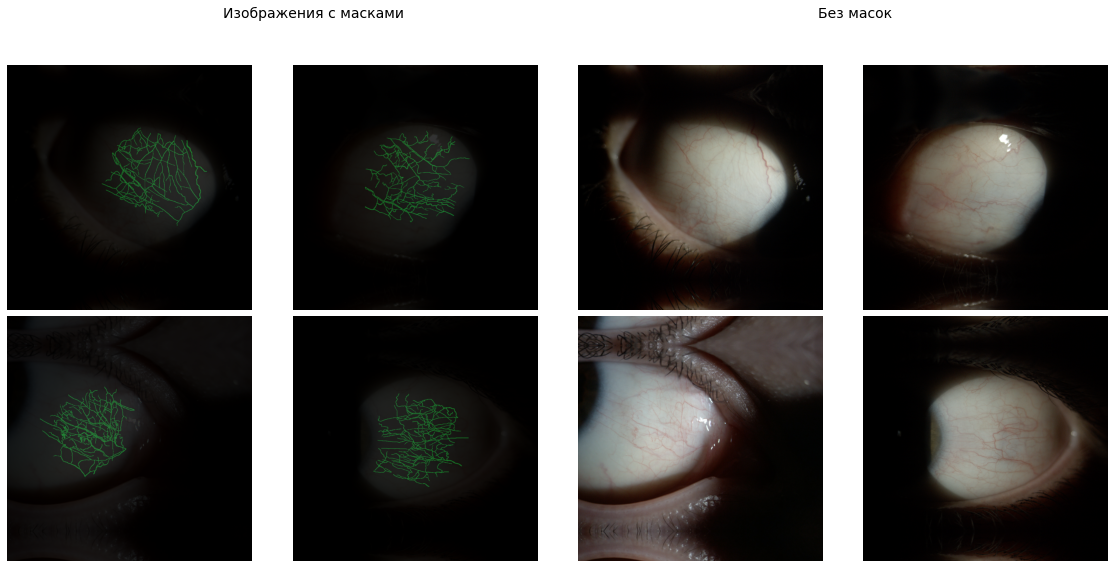

In [ ]:
# Посмотрим на картинки из датасета

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Изображения с масками {" " * 90} Без масок', fontsize=14)

for i, sample in zip(range(4), dataset):
    transformed = transforms['test'](**sample)
    image, mask = transformed["image"], transformed["mask"]

    image_with_mask = draw_segmentation_masks((image.cpu() * 255).type(torch.uint8), mask.type(torch.bool))
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)

    axs[i // 2, (i % 2)].imshow(image_with_mask)
    axs[i // 2, (i % 2)].axis('off')

    image = np.moveaxis(image.cpu().numpy(), 0, -1)    
    axs[i // 2, (i % 2)+2].imshow(image)
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [ ]:
print("Обучающей выборки " ,len(listdir("/content/drive/MyDrive/hacks-ai/vladivostok/data/train")) // 2)
print("Тестовой выборки " ,len(listdir("/content/drive/MyDrive/hacks-ai/vladivostok/data/test")))

# разделим датасет на тренировочный и валидационный
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2)
train_dataset = DatasetPart(dataset, train_indices, transform=transforms['train'])
valid_dataset = DatasetPart(dataset, test_indices, transform=transforms['test'])

train_loader = torch.utils.data.DataLoader(train_dataset, 1,
                                   num_workers=4,
                                   shuffle=True, drop_last=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 1,
                                   num_workers=4,
                                   shuffle=True, drop_last=True)

Обучающей выборки  657
Тестовой выборки  308


## Метрики и вспомогательные функции

In [ ]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.plot(val_history, c='orange', label='validation', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()


# F1-мера
class SoftDice:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon

    def __call__(self, predictions: List[Dict[str, torch.Tensor]],
                 targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        numerator = torch.sum(2 * predictions * targets)
        denominator = torch.sum(predictions + targets)
        return numerator / (denominator + self.epsilon)

# Метрика полноты
class Recall:
    def __init__(self, epsilon=1e-8, b=1):
        self.epsilon = epsilon
        self.a = b*b

    def __call__(self, predictions: List[Dict[str, torch.Tensor]],
                 targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        numerator = torch.sum(predictions * targets)
        denominator = torch.sum(targets)

        return numerator / (denominator + self.epsilon)

# Метрика точности
class Accuracy:
    def __init__(self, epsilon=1e-8, b=1):
        self.epsilon = epsilon
        self.a = b*b

    def __call__(self, predictions: list, targets: list) -> torch.Tensor:
        numerator = torch.sum(targets)
        denominator = torch.sum(predictions * targets)

        return numerator / (denominator + self.epsilon)


def make_metrics():

    def exp_dice(pred, target):
        return SoftDice()(torch.exp(pred[:, 1:]), target[:, 1:])

    def accuracy(pred, target):
        return Accuracy()(torch.exp(pred[:, 1:]), target[:, 1:])

    def exp_recall(pred, target):
        return Recall()(torch.exp(pred[:, 1:]), target[:, 1:])

    return [('exp_dice', exp_dice),
            ('accuracy', accuracy),
            ('recall', exp_recall)]

## Класс для тренировки модели

In [ ]:
class UnetTrainer:
    """
    Класс, реализующий обучение модели
    """

    def __init__(self, model: nn.Module, optimizer: torch.optim.Optimizer,
                 criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
                 device: str, metric_functions: List[Tuple[str, Callable]] = [],
                 epoch_number: int = 0,
                 lr_scheduler: Optional[Any] = None):
        self.model = model
        self.optimizer = optimizer  
        self.criterion = criterion
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.metric_functions = metric_functions
        self.epoch_number = epoch_number


    @torch.no_grad()
    def evaluate_batch(self, val_iterator: Iterator, eval_on_n_batches: int) -> Optional[Dict[str, float]]:     
        predictions = []
        targets = []

        losses = []

        for real_batch_number in range(eval_on_n_batches):
            try:
                batch = next(val_iterator)

                xs = batch['image'].to(self.device)
                ys_true = batch['mask'].to(self.device)
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break
            ys_pred = self.model.eval()(xs)
            loss = self.criterion(ys_pred, ys_true)

            losses.append(loss.item())

            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {'loss': np.mean(losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        return metrics


    @torch.no_grad()
    def evaluate(self, val_loader, eval_on_n_batches: int = 1) -> Dict[str, float]:
        """
        Вычисление метрик для эпохи
        """
        metrics_sum = defaultdict(float)
        num_batches = 0

        val_iterator = iter(val_loader)

        while True:
            batch_metrics = self.evaluate_batch(val_iterator, eval_on_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics


    def fit_batch(self, train_iterator: Iterator, update_every_n_batches: int) -> Optional[Dict[str, float]]:
        """
        Тренировка модели на одном батче
        """

        self.optimizer.zero_grad()

        predictions = []
        targets = []

        losses = []

        for real_batch_number in range(update_every_n_batches):
            try:
                batch = next(train_iterator)

                xs = batch['image'].to(self.device)
                ys_true = batch['mask'].to(self.device)
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            ys_pred = self.model.train()(xs)
            loss = self.criterion(ys_pred, ys_true)

            (loss / update_every_n_batches).backward()

            losses.append(loss.item())

            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())

        self.optimizer.step()

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {'loss': np.mean(losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        return metrics


    def fit_epoch(self, train_loader, update_every_n_batches: int = 1) -> Dict[str, float]:
        """
        Одна эпоха тренировки модели
        """

        metrics_sum = defaultdict(float)
        num_batches = 0

        train_iterator = iter(train_loader)

        while True:
            batch_metrics = self.fit_batch(train_iterator, update_every_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics


    def fit(self, train_loader, num_epochs: int,
            val_loader = None, update_every_n_batches: int = 1,
            ) -> Dict[str, np.ndarray]:
        """
        Метод, тренирующий модель и вычисляющий метрики для каждой эпохи
        """

        summary = defaultdict(list)

        def save_metrics(metrics: Dict[str, float], postfix: str = '') -> None:
          # Сохранение метрик в summary
            nonlocal summary, self

            for metric in metrics:
                metric_name, metric_value = f'{metric}{postfix}', metrics[metric]

                summary[metric_name].append(metric_value)

        for _ in tqdm(range(num_epochs - self.epoch_number), initial=self.epoch_number, total=num_epochs):
            self.epoch_number += 1

            train_metrics = self.fit_epoch(train_loader, update_every_n_batches)

            with torch.no_grad():
                save_metrics(train_metrics, postfix='_train')

                if val_loader is not None:
                    test_metrics = self.evaluate(val_loader)
                    save_metrics(test_metrics, postfix='_test')

            if self.lr_scheduler is not None:
                self.lr_scheduler.step()

        summary = {metric: np.array(summary[metric]) for metric in summary}

        return summary


## Модель

### Загружаем модель

In [ ]:
# Подргружаем модель
model = smp.Unet('resnet50', activation='logsoftmax', classes=2)

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    model = model.cuda()
    print('The model loaded to CUDA.')
else:
    print('CUDA is not available.')


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

The model loaded to CUDA.


### Задаём функцию потерь

In [ ]:
def make_criterion():
    soft_dice = SoftDice()

    def exp_dice(pred, target):
        return 1 - soft_dice(torch.exp(pred[:, 1:]), target[:, 1:])

    return exp_dice

criterion = make_criterion()
optimizer = torch.optim.Adam(model.parameters(), 0.0001)

In [ ]:
# Обучаем модель
trainer = UnetTrainer(model, optimizer, criterion, 'cuda', metric_functions=make_metrics())
summary = trainer.fit(train_loader, 10, val_loader=valid_loader)

In [ ]:
#torch.save(model.state_dict(), '/content/drive/MyDrive/hacks-ai/vladivostok/models_parameters/v1_20220911-2325.pt')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/hacks-ai/vladivostok/models_parameters/v1_20220911-2320.pt'))

<All keys matched successfully>

## Посмотрим метрики обученной модели на валидационном датасете

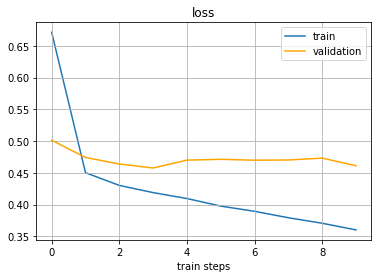

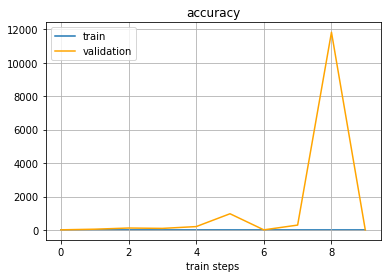

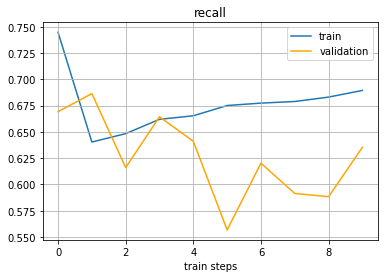

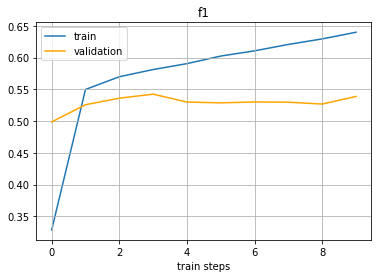

In [ ]:
# Функция потерь
plot_history(summary['loss_train'], summary['loss_test'])

# Точность
plot_history(summary['accuracy_train'], summary['accuracy_test'], "accuracy")
# Полнота
plot_history(summary['recall_train'], summary['recall_test'], "recall")
# F1
plot_history(summary['exp_dice_train'], summary['exp_dice_test'], "f1")

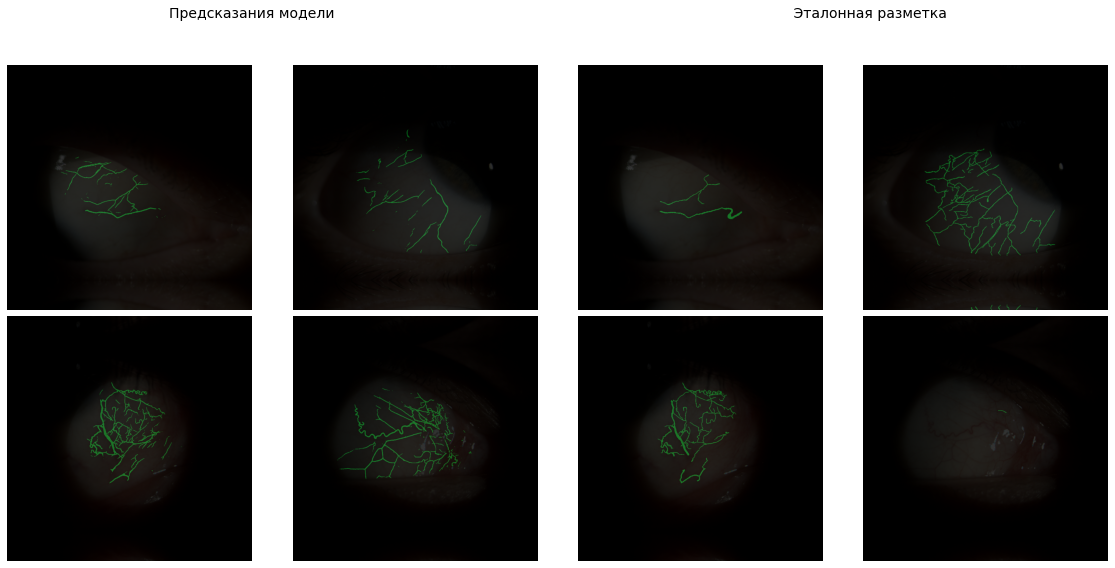

In [ ]:
# Посмотрим на картинки предсказаний

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Предсказания модели {" "*100} Эталонная разметка', fontsize=14)

for i, sample in zip(range(4), valid_dataset):
    image = sample['image'].to('cuda') if torch.cuda.is_available() else sample['image']
    true_mask = sample['mask'].to('cuda') if torch.cuda.is_available() else sample['mask']

    prediction = model.eval()(image.unsqueeze(dim=0))

    image = (image.cpu() * 255).type(torch.uint8)
    pred_mask = (torch.exp(prediction[0]) > 0.5).cpu()

    image_with_mask = draw_segmentation_masks(image, pred_mask)
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)

    axs[i // 2, (i % 2)].imshow(image_with_mask)
    axs[i // 2, (i % 2)].axis('off')


    image_with_mask = draw_segmentation_masks(image, true_mask.type(torch.bool))
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)
    axs[i // 2, (i % 2)+2].imshow(image_with_mask)
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

## Предсказание маски для тестового датасета

In [ ]:
test_dataset = EyeDataset('/content/drive/MyDrive/hacks-ai/vladivostok/data/test', is_train=False)

# Проверим состояние загруженного датасета
for msg in test_dataset.make_report():
  print(msg)


Найдено 301 изображений
Найдено 301 изображений без разметки


### Посмотрим на результат предсказания

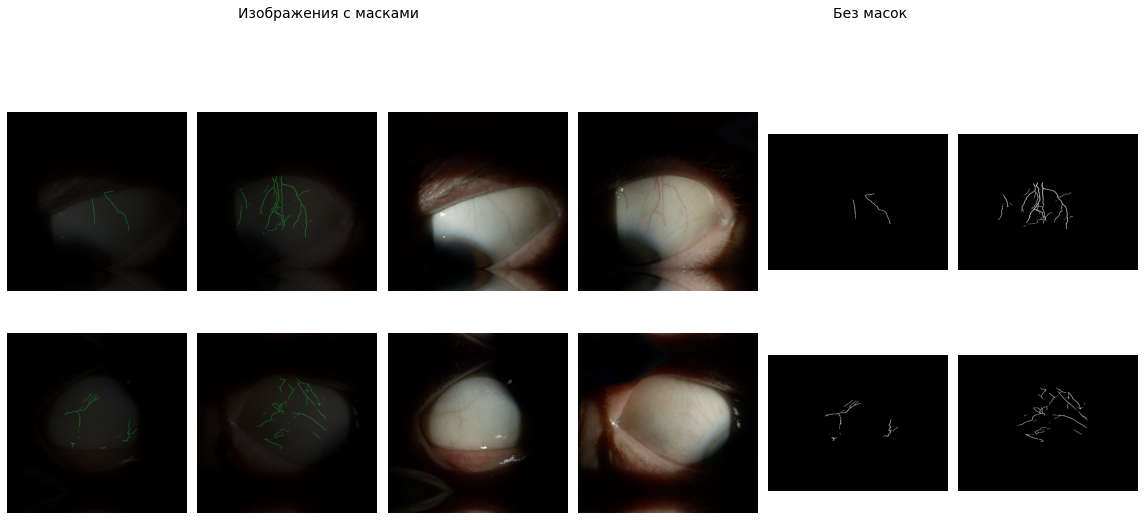

In [ ]:
fig, axs = plt.subplots(2, 6, figsize=(16,8))
fig.suptitle(f'Изображения с масками {" " * 90} Без масок', fontsize=14)

for i, sample in zip(range(4), test_dataset):
    image = transforms['test'](image=sample['image'])['image']
    if torch.cuda.is_available():
        image = image.to('cuda')

    mask = model.eval()(image.unsqueeze(dim=0))
    mask = (torch.exp(mask[0]) > 0.5).cpu()

    image_with_mask = draw_segmentation_masks((image.cpu() * 255).type(torch.uint8), mask.type(torch.bool))
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)

    axs[i // 2, (i % 2)].imshow(image_with_mask)
    axs[i // 2, (i % 2)].axis('off')

    image = np.moveaxis(image.cpu().numpy(), 0, -1)    
    axs[i // 2, (i % 2)+2].imshow(image)
    axs[i // 2, (i % 2)+2].axis('off')

    mask_image = mask[0].numpy()
    mask_image = (mask_image == False).astype(np.uint8)
    mask_image = cv2.resize(mask_image, dsize=(1624, 1232), interpolation=cv2.INTER_CUBIC)
    axs[i // 2, (i % 2) + 4].imshow(mask_image, cmap='gray')
    axs[i // 2, (i % 2) + 4].axis('off')


fig.tight_layout()
fig.subplots_adjust(top=0.88)

### Предсказание масок для тестового набора

In [ ]:
for i, sample in tqdm(enumerate(test_dataset), total=len(test_dataset)):
    image = transforms['test'](image=sample['image'])['image']
    if torch.cuda.is_available():
        image = image.to('cuda')

    mask = model.eval()(image.unsqueeze(dim=0))
    mask = (torch.exp(mask[0]) > 0.5).cpu()
    mask_image = mask[0].numpy().astype(np.uint8)

    #увеличение размера до заданного 1624x1232 
    mask_image = cv2.resize(mask_image, dsize=(1624, 1624), interpolation=cv2.INTER_CUBIC)
    mask_image = mask_image[196:1428, :]

    #инверсия, чтобы маска была чёрной, а фон белым
    mask_image = mask_image == 0

    Image.fromarray(mask_image).save(f'/content/drive/MyDrive/hacks-ai/vladivostok/results/v1.1/{test_dataset.get_image_name(i)}.png')





100%|██████████| 301/301 [01:19<00:00,  3.78it/s]
